##### Copyright 2023 The TF-Agents Authors.

In [43]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train a Deep Q Network with TF-Agents

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/agents/docs/tutorials/1_dqn_tutorial.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Setup

If you haven't installed the following dependencies, run:

In [44]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease               
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease                 
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease          
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease    
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)

In [45]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.ddpg import ddpg_agent
from tf_agents.agents.ddpg import actor_network
from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [46]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [47]:
tf.version.VERSION

'2.15.1'

## Hyperparameters

In [48]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

## Environment

In Reinforcement Learning (RL), an environment represents the task or problem to be solved. Standard environments can be created in TF-Agents using `tf_agents.environments` suites. TF-Agents has suites for loading environments from sources such as the OpenAI Gym, Atari, and DM Control.

Load the Pendulum environment from the OpenAI Gym suite. 

In [49]:
import gymnasium as gym
env_name = 'Pendulum-v1'
env = suite_gym.load(env_name)

You can render this environment to see how it looks. A free-swinging pole is attached to a cart.  The goal is to move the cart right or left in order to keep the pole pointing up.

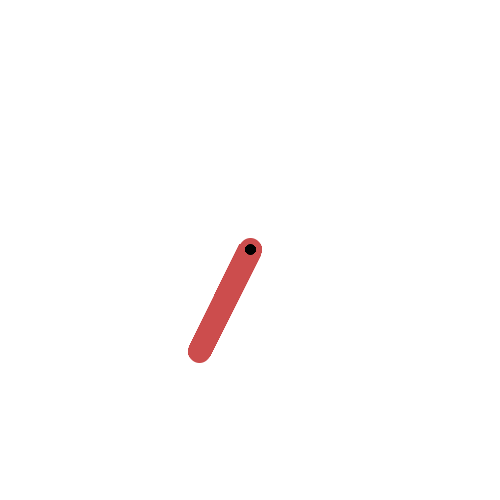

In [50]:
#@test {"skip": true}
env.reset()
PIL.Image.fromarray(env.render())

The `environment.step` method takes an `action` in the environment and returns a `TimeStep` tuple containing the next observation of the environment and the reward for the action.

The `time_step_spec()` method returns the specification for the `TimeStep` tuple. Its `observation` attribute shows the shape of observations, the data types, and the ranges of allowed values. The `reward` attribute shows the same details for the reward.


In [51]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(3,), dtype=dtype('float32'), name='observation', minimum=[-1. -1. -8.], maximum=[1. 1. 8.])


In [52]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


The `action_spec()` method returns the shape, data types, and allowed values of valid actions.

In [53]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(1,), dtype=dtype('float32'), name='action', minimum=-2.0, maximum=2.0)


In the Pendulum environment:

observation is an array of 3 floats:
- cos(θ): horizontal component of the pendulum
- sin(θ): vertical component of the pendulum
- θ̇: angular velocity of the pendulum

reward is a scalar float value computed as:
r=−(θ2+0.1θ˙2+0.001u2)


action is a scalar continuous value (Box space):
A single float between -2.0 and 2.0, representing the torque applied to the pendulum

In [54]:
time_step = env.reset()
print('Time step:')
print(time_step)

# Acción continua: torque entre -2.0 y 2.0
action = np.array([0.5], dtype=np.float32)  # ejemplo: torque = 0.5

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)


Time step:
TimeStep(
{'step_type': array(0, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([-0.35884088,  0.9333987 , -0.2626126 ], dtype=float32)})
Next time step:
TimeStep(
{'step_type': array(1, dtype=int32),
 'reward': array(-3.762301, dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([-0.38263586,  0.92389923,  0.51243645], dtype=float32)})


Usually two environments are instantiated: one for training and one for evaluation. 

In [55]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

The Cartpole environment, like most environments, is written in pure Python. This is converted to TensorFlow using the `TFPyEnvironment` wrapper.

The original environment's API uses Numpy arrays. The `TFPyEnvironment` converts these to `Tensors` to make it compatible with Tensorflow agents and policies.


In [56]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agent

The algorithm used to solve an RL problem is represented by an `Agent`. TF-Agents provides standard implementations of a variety of `Agents`, including:

-   [DQN](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) (used in this tutorial)
-   [REINFORCE](https://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)
-   [DDPG](https://arxiv.org/pdf/1509.02971.pdf)
-   [TD3](https://arxiv.org/pdf/1802.09477.pdf)
-   [PPO](https://arxiv.org/abs/1707.06347)
-   [SAC](https://arxiv.org/abs/1801.01290)

The DQN agent can be used in any environment which has a discrete action space.

At the heart of a DQN Agent is a `QNetwork`, a neural network model that can learn to predict `QValues` (expected returns) for all actions, given an observation from the environment.

We will use `tf_agents.networks.` to create a `QNetwork`. The network will consist of a sequence of `tf.keras.layers.Dense` layers, where the final layer will have 1 output for each possible action.

In [57]:
fc_layer_params = (256, 256)

# Actor network (produce acción continua)
actor_net = actor_network.ActorNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params,
    activation_fn=tf.keras.activations.relu
)

# Critic network (calcula Q(s, a))
critic_net = critic_network.CriticNetwork(
    (train_env.observation_spec(), train_env.action_spec()),
    joint_fc_layer_params=fc_layer_params,
    activation_fn=tf.keras.activations.relu
)

# Añadir: contador de pasos (necesario antes de crear el agente)
train_step_counter = tf.Variable(0)



Now use `tf_agents.agents.dqn.dqn_agent` to instantiate a `DqnAgent`. In addition to the `time_step_spec`, `action_spec` and the QNetwork, the agent constructor also requires an optimizer (in this case, `AdamOptimizer`), a loss function, and an integer step counter.

In [58]:
# Learning rates recomendados para DDPG en Pendulum
actor_learning_rate = 1e-4   # actor suele ser más pequeño
critic_learning_rate = 1e-3  # critic puede ser mayor

# Usar optimizadores legacy para evitar KeyError en TF >= 2.14
actor_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=actor_learning_rate)
critic_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=critic_learning_rate)


agent = ddpg_agent.DdpgAgent(
    time_step_spec=train_env.time_step_spec(),
    action_spec=train_env.action_spec(),
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=actor_optimizer,
    critic_optimizer=critic_optimizer,
    ou_stddev=0.2,               # ruido para recolección
    ou_damping=0.15,             # damping OU
    target_update_tau=0.005,     # soft update coeficiente tau
    target_update_period=1,      # cada cuántos pasos actualizar target nets
    train_step_counter=train_step_counter
)

agent.initialize()


## Policies

A policy defines the way an agent acts in an environment. Typically, the goal of reinforcement learning is to train the underlying model until the policy produces the desired outcome.

In this tutorial:

-   The desired outcome is keeping the pole balanced upright over the cart.
-   The policy returns an action (left or right) for each `time_step` observation.

Agents contain two policies: 

-   `agent.policy` — The main policy that is used for evaluation and deployment.
-   `agent.collect_policy` — A second policy that is used for data collection.


In [59]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

Policies can be created independently of agents. For example, use `tf_agents.policies.random_tf_policy` to create a policy which will randomly select an action for each `time_step`.

In [60]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

To get an action from a policy, call the `policy.action(time_step)` method. The `time_step` contains the observation from the environment. This method returns a `PolicyStep`, which is a named tuple with three components:

-   `action` — the action to be taken (in this case, `0` or `1`)
-   `state` — used for stateful (that is, RNN-based) policies
-   `info` — auxiliary data, such as log probabilities of actions

In [61]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('Pendulum-v1'))

In [62]:
time_step = example_environment.reset()

In [63]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.4726205]], dtype=float32)>, state=(), info=())

## Metrics and Evaluation

The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode. Several episodes are run, creating an average return.

The following function computes the average return of a policy, given the policy, environment, and a number of episodes.


In [64]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

Running this computation on the `random_policy` shows a baseline performance in the environment.

In [65]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

-1233.492

## Replay Buffer

In order to keep track of the data collected from the environment, we will use [Reverb](https://deepmind.com/research/open-source/Reverb), an efficient, extensible, and easy-to-use replay system by Deepmind. It stores experience data when we collect trajectories and is consumed during training.

This replay buffer is constructed using specs describing the tensors that are to be stored, which can be obtained from the agent using agent.collect_data_spec.


In [66]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpy0dymay7.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmpy0dymay7
[reverb/cc/platform/default/server.cc:71] Started replay server on port 40225


For most agents, `collect_data_spec` is a named tuple called `Trajectory`, containing the specs for observations, actions, rewards, and other items.

In [67]:
agent.collect_data_spec

Trajectory(
{'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(3,), dtype=tf.float32, name='observation', minimum=array([-1., -1., -8.], dtype=float32), maximum=array([1., 1., 8.], dtype=float32)),
 'action': BoundedTensorSpec(shape=(1,), dtype=tf.float32, name='action', minimum=array(-2., dtype=float32), maximum=array(2., dtype=float32)),
 'policy_info': (),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32))})

In [68]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

## Data Collection

Now execute the random policy in the environment for a few steps, recording the data in the replay buffer.

Here we are using 'PyDriver' to run the experience collecting loop. You can learn more about TF Agents driver in our [drivers tutorial](https://www.tensorflow.org/agents/tutorials/4_drivers_tutorial).

In [69]:
#@test {"skip": true}
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'step_type': array(1, dtype=int32),
  'reward': array(-7.6097107, dtype=float32),
  'discount': array(1., dtype=float32),
  'observation': array([-0.8253292 ,  0.56465185, -1.9044331 ], dtype=float32)}),
 ())

The replay buffer is now a collection of Trajectories.

In [70]:
# For the curious:
# Uncomment to peel one of these off and inspect it.
# iter(replay_buffer.as_dataset()).next()

The agent needs access to the replay buffer. This is provided by creating an iterable `tf.data.Dataset` pipeline which will feed data to the agent.

Each row of the replay buffer only stores a single observation step. But since the DQN Agent needs both the current and next observation to compute the loss, the dataset pipeline will sample two adjacent rows for each item in the batch (`num_steps=2`).

This dataset is also optimized by running parallel calls and prefetching data.

In [71]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

<_PrefetchDataset element_spec=(Trajectory(
{'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 3), dtype=tf.float32, name=None),
 'action': TensorSpec(shape=(64, 2, 1), dtype=tf.float32, name=None),
 'policy_info': (),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

In [72]:
iterator = iter(dataset)
print(iterator)

In [73]:
# For the curious:
# Uncomment to see what the dataset iterator is feeding to the agent.
# Compare this representation of replay data 
# to the collection of individual trajectories shown earlier.

# iterator.next()

## Training the agent

Two things must happen during the training loop:

-   collect data from the environment
-   use that data to train the agent's neural network(s)

This example also periodicially evaluates the policy and prints the current score.

The following will take ~5 minutes to run.

In [74]:
#@test {"skip": true}
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1798) so Table uniform_table is accessed directly without gRPC.


step = 200: loss = 0.2467060685157776
step = 400: loss = 0.14432665705680847
step = 600: loss = 0.5776972770690918
step = 800: loss = 0.26063090562820435
step = 1000: loss = 0.21249040961265564
step = 1000: Average Return = -1522.522216796875
step = 1200: loss = 0.6000329256057739
step = 1400: loss = 0.5579452514648438
step = 1600: loss = 0.6453751921653748
step = 1800: loss = 0.492961049079895
step = 2000: loss = 2.6709911823272705
step = 2000: Average Return = -786.5807495117188
step = 2200: loss = 0.9928977489471436
step = 2400: loss = 2.491800546646118
step = 2600: loss = 3.210827350616455
step = 2800: loss = 3.116885185241699
step = 3000: loss = 6.706164360046387
step = 3000: Average Return = -926.9158325195312
step = 3200: loss = 5.387777328491211
step = 3400: loss = 4.207809925079346
step = 3600: loss = 5.162461757659912
step = 3800: loss = 4.60039758682251
step = 4000: loss = 4.323944568634033
step = 4000: Average Return = -262.63677978515625
step = 4200: loss = 5.2892494201660

# Ambiente del Pendulum

## Características del entorno

- **NO** da recompensas positivas
- **Objetivo**: mantener la varilla vertical hacia arriba, con:
  - Cero velocidad angular
  - Aplicando poca energía (acción pequeña)

---

## Función de recompensa oficial

$$r = -(\theta^2 + 0.1\dot{\theta}^2 + 0.001u^2)$$

donde:

- $\theta$ = ángulo respecto a la vertical
- $\dot{\theta}$ = velocidad angular  
- $u$ = torque aplicado

---

## Interpretación de las recompensas

- **Lo mejor que puedes obtener**: retorno cercano a 0
- **Políticas malas**: retornos entre $-1500$ y $-2000$
- **Política decente**: entre $-300$ y $-100$
- **Política excelente**: puede llegar a $-200$ → $-100$ → $-50$

---

## 💡 Punto clave

**Nunca obtendrás retornos positivos.**

El "éxito" es **acercarse a 0**, no superar 0.

## Visualization


### Plots

Use `matplotlib.pyplot` to chart how the policy improved during training.

One iteration of `Cartpole-v0` consists of 200 time steps. The environment gives a reward of `+1` for each step the pole stays up, so the maximum return for one episode is 200. The charts shows the return increasing towards that maximum each time it is evaluated during training. (It may be a little unstable and not increase monotonically each time.)

(-1593.808588027954, 250.0)

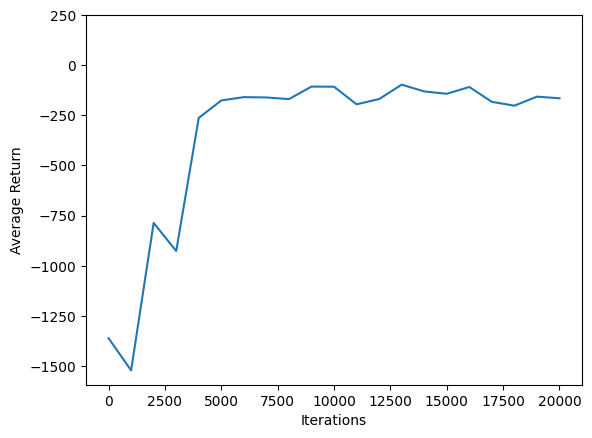

In [75]:
#@test {"skip": true}

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

### Videos

Charts are nice. But more exciting is seeing an agent actually performing a task in an environment. 

First, create a function to embed videos in the notebook.

In [76]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

Now iterate through a few episodes of the Cartpole game with the agent. The underlying Python environment (the one "inside" the TensorFlow environment wrapper) provides a `render()` method, which outputs an image of the environment state. These can be collected into a video.

In [77]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")

[swscaler @ 0x5a08f7187a00] Warning: data is not aligned! This can lead to a speed loss


For fun, compare the trained agent (above) to an agent moving randomly. (It does not do as well.)

In [78]:
create_policy_eval_video(random_policy, "random-agent")

[swscaler @ 0x5a3cf8345a00] Warning: data is not aligned! This can lead to a speed loss
